In [40]:
%matplotlib inline

In [41]:
import sys
sys.path.insert(0, '/Users/Copper/git/yellowbrick')

In [42]:
##########################################################################
## Imports
##########################################################################

# NOTE: must import mplot3d to load the 3D projection
import mpl_toolkits.mplot3d # noqa
import matplotlib.pyplot as plt

from yellowbrick.features.base import MultiFeatureVisualizer
from yellowbrick.style import palettes
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.draw import manual_legend

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [43]:
##########################################################################
##2D and #3D PCA Visualizer
##########################################################################

class PCADecomposition(MultiFeatureVisualizer):
    """
    Produce a two or three dimensional principal component plot of a data array
    projected onto it's largest sequential principal components. It is common
    practice to scale the data array ``X`` before applying a PC decomposition.
    Variable scaling can be controlled using the ``scale`` argument.

    Parameters
    ----------
    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes.
        will be used (or generated if required).

    features: list, default: None
        a list of feature names to use
        If a DataFrame is passed to fit and features is None, feature
        names are selected as the columns of the DataFrame.

    scale : bool, default: True
        Boolean that indicates if user wants to scale data.

    proj_dim : int, default: 2
        Dimension of the PCA visualizer.

    proj_features : bool, default: False
        Boolean that indicates if the user wants to project the features
        in the projected space. If True the plot will be similar to a biplot.

    color : list or tuple of colors, default: None
        Specify the colors for each individual class.
        
    classes : list, default: None
        a list of class names for the legend
        If classes is None and a y value is passed to fit then the classes
        are selected from the target vector..

    colormap : string or cmap, default: None
        Optional string or matplotlib cmap to colorize lines.
        Use either color to colorize the lines on a per class basis or
        colormap to color them on a continuous scale.

    random_state : int, RandomState instance or None, optional (default None)
        If input data is larger than 500x500 and the number of components to
        extract is lower than 80% of the smallest dimension of the data, then
        the more efficient `randomized` solver is enabled, this parameter sets
        the random state on this solver.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------
    >>> from sklearn import datasets
    >>> iris = datasets.load_iris()
    >>> X = iris.data
    >>> y = iris.target
    >>> visualizer = PCADecomposition()
    >>> visualizer.fit_transform(X)
    >>> visualizer.poof()

    """
    def __init__(self,
                 ax=None,
                 features=None,
                 scale=True,
                 proj_dim=2,
                 proj_features=False,
                 color=None,
                 classes=None,
                 colormap=palettes.DEFAULT_SEQUENCE,
                 random_state=None,
                 **kwargs):
        super(PCADecomposition, self).__init__(ax=ax,
                                               features=features,
                                               **kwargs)

        if proj_dim not in (2, 3):
            raise YellowbrickValueError("proj_dim object is not 2 or 3.")

        # Data Parameters
        self.scale = scale
        self.proj_dim = proj_dim
        self.proj_features = proj_features

        # Create the PCA transformer
        self.pca_transformer = Pipeline(
            [('scale', StandardScaler(with_std=self.scale)),
             ('pca', PCA(self.proj_dim, random_state=random_state))]
        )

        # Visual Parameters
        self.color = color
        self.classes_ = classes
        self.colormap = colormap

    def fit(self, X, y=None, **kwargs):
        """
        Fits the PCA transformer, transforms the data in X, then draws the
        decomposition in either 2D or 3D space as a scatter plot.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features.

        y : ndarray or Series of length n
            An array or series of target or class values.

        Returns
        -------
        self : visualizer
            Returns self for use in Pipelines
        """
        super(PCADecomposition, self).fit(X=X, y=y, **kwargs)
        self.pca_transformer.fit(X)
        self.pca_components_ = self.pca_transformer.named_steps['pca'].components_
        return self

    def transform(self, X, y=None, **kwargs):
        self.pca_features_ = self.pca_transformer.transform(X)
        self.draw()
        return self.pca_features_

    def draw(self, **kwargs):
        X = self.pca_features_
        if self.proj_dim == 2:
            self.ax.scatter(X[:, 0], X[:, 1], c=self.color, cmap=self.colormap)
            if self.proj_features:
                x_vector = self.pca_components_[0]
                y_vector = self.pca_components_[1]
                max_x = max(X[:, 0])
                max_y = max(X[:, 1])
                for i in range(self.pca_components_.shape[1]):
                    self.ax.arrow(
                        x=0, y=0,
                        dx=x_vector[i] * max_x,
                        dy=y_vector[i] * max_y,
                        color='r', head_width=0.05,
                        width=0.005,
                    )
                    self.ax.text(
                        x_vector[i] * max_x * 1.05,
                        y_vector[i] * max_y * 1.05,
                        self.features_[i], color='r'
                    )
        if self.proj_dim == 3:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(111, projection='3d')
            self.ax.scatter(X[:, 0], X[:, 1], X[:, 2],
                            c=self.color, cmap=self.colormap)
            if self.proj_features:
                x_vector = self.pca_components_[0]
                y_vector = self.pca_components_[1]
                z_vector = self.pca_components_[2]
                max_x = max(X[:, 0])
                max_y = max(X[:, 1])
                max_z = max(X[:, 1])
                for i in range(self.pca_components_.shape[1]):
                    self.ax.plot(
                        [0, x_vector[i] * max_x],
                        [0, y_vector[i] * max_y],
                        [0, z_vector[i] * max_z],
                        color='r'
                    )
                    self.ax.text(
                        x_vector[i] * max_x * 1.05,
                        y_vector[i] * max_y * 1.05,
                        z_vector[i] * max_z * 1.05,
                        self.features_[i], color='r'
                    )
        return self.ax

    def finalize(self, **kwargs):
        # Set the title
        self.ax.set_title('Principal Component Plot')
        self.ax.set_xlabel('Principal Component 1')
        self.ax.set_ylabel('Principal Component 2')
        if self.proj_dim == 3:
            self.ax.set_zlabel('Principal Component 3')
        if self.classes_ is not None:
              manual_legend(self, self.classes_, self.color, frameon=True, loc='best'
            )


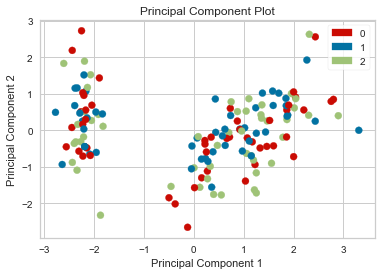

In [48]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

_, ax = plt.subplots()
visualizer = PCADecomposition(color=('r', 'b', 'g'), classes=('0','1', '2'))
visualizer.fit_transform(X)
visualizer.poof()